# Data streaming

## Task 3. Flow data discretization task

Group 97

We aim to learn a sequential model from NetFlow data from an infected host (unidirectional netflows). Consider scenario 10 from the CTU-13 dataset. Remove all background flows from the data. You are to discretize the NetFlows. Investigate the data from one of the infected hosts. Select and visualize two features that you believe are most relevant for modeling the behavior of the infected host. Discretize these featues using any of the methods discussed in class (combine the two values into a single discrete value). Do you observe any behavior in the two features that could be useful for detecting the infection? Explain. Apply the discretization to data from all hosts in the selected scenario.

Per documentation, the distribution of labels in the NetFlows for scenario 10 in the dataset is:

Total flows | Botnet flows    | Normal flows  | C&C flows  | Background flows
------------|-----------------|---------------|------------|-------------------
1,309,791   | 106,315 (8.11%) | 15,847 (1.2%) | 37 (.002%) | 1,187,592 (90.67%)

Reference: "An empirical comparison of botnet detection methods" Sebastian Garcia, Martin Grill, Jan Stiborek and Alejandro Zunino. Computers and Security Journal, Elsevier. 2014. Vol 45, pp 100-123. http://dx.doi.org/10.1016/j.cose.2014.05.011

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

np.random.seed(42)
random.seed(42)
%matplotlib inline

In [2]:
# define filepath for scenario 10 dataset
filepath = './data/capture20110818.pcap.netflow.labeled'

# read data from the file
f = open(filepath, 'r')
lines = f.readlines()
f.close()
data = lines[1:] # drop the header

In [3]:
def preprocessing_remove_Background(data):
    '''data preprocessing
    Input
    -----
    data: string of a data flow
    
    Return
    ------
    o = None, if Background flow (to be removed)
    o = cleaned, formated data, if not Background flow
    '''
    if not 'Background' in data:
        s = data.split('\t')
        s = [x for x in s if x] # remove empty elements
        if len(s) < 12: # special fix for an outlier string @2011-08-18 12:18:31.264
            s = s[0].rsplit(' ', 11) 
        o = np.array([pd.to_datetime(s[0], format='%Y-%m-%d %H:%M:%S.%f'), # timestamp
                      float(s[1]), # duration
                      s[2], # protocol
                      s[3].split(':')[0], # ScrAddr
                      s[5].split(':')[0], # DstAddr
                      s[6].lstrip('_').rstrip('_').rstrip(), # flags
                      int(s[7]), # Tos
                      int(s[8]), # packets
                      int(s[9]), # bytes
                      int(s[10]), # flows
                      s[11].rstrip('\n').rstrip() # label
                     ])
    else: # if Background flow
        o = None
    return o

In [4]:
df = list(map(preprocessing_remove_Background, data)) # data preprocessing
df = [x for x in df if isinstance(x, np.ndarray)] # remove background flows
df = pd.DataFrame(df, columns=['Time', 'Duration', 'Protocol', 'ScrAddr', 'DstAddr', 
                               'Flags', 'Tos', 'Packets', 'Bytes', 'Flows', 'Label'])

In [5]:
df.head()

,Time,Duration,Protocol,ScrAddr,DstAddr,Flags,Tos,Packets,Bytes,Flows,Label
0,2011-08-18 10:19:13.347,4.985,TCP,147.32.80.13,147.32.85.88,PA,0,91,86277,1,LEGITIMATE
1,2011-08-18 10:19:13.392,0.000,TCP,147.32.86.110,74.125.232.214,A,0,1,66,1,LEGITIMATE
2,2011-08-18 10:19:13.411,4.921,TCP,147.32.85.88,147.32.80.13,A,0,49,3234,1,LEGITIMATE
3,2011-08-18 10:19:13.460,4.742,TCP,147.32.84.59,74.125.108.208,A,0,118,7080,1,LEGITIMATE
4,2011-08-18 10:19:13.486,0.000,TCP,147.32.84.59,74.125.232.215,A,0,1,60,1,LEGITIMATE


## 1. Visualisation

We then visualise the flows related to some specific infected hosts to identify the right features for discretisation. We'd like to investigate the data from the most frequenct infected host. Per documentation, there are ten infected hosts in this dataset: 147.32.84.165, 147.32.84.191, 147.32.84.192, 147.32.84.193, 147.32.84.204, 147.32.84.205, 147.32.84.206, 147.32.84.207, 147.32.84.208 and 147.32.84.209.

### *Selection of infected host*

In [6]:
infected_hosts = ['147.32.84.165', '147.32.84.191', '147.32.84.192', '147.32.84.193',
                  '147.32.84.204', '147.32.84.205', '147.32.84.206', '147.32.84.207', 
                  '147.32.84.208', '147.32.84.209']

In [7]:
ip_addr = df[['ScrAddr', 'DstAddr']].values.reshape(-1)
ip_addr = [ip for ip in ip_addr if ip in infected_hosts] # filter for only the infected hosts

# count the frequency of each ip address
ip_addr_count = np.unique(ip_addr, return_counts=True)
ip_addr_count = pd.DataFrame({'ip' : ip_addr_count[0],
                              'freq' : ip_addr_count[1]})
ip_addr_count.sort_values('freq', ascending=False, inplace=True) # sort by frequency

In [8]:
ip_addr_count

,ip,freq
5,147.32.84.205,36261
6,147.32.84.206,34140
8,147.32.84.208,33723
4,147.32.84.204,33665
7,147.32.84.207,32384
1,147.32.84.191,31788
2,147.32.84.192,31675
3,147.32.84.193,30508
9,147.32.84.209,29771
0,147.32.84.165,29526


In [9]:
print('The size of non-infected data flows is {}.'.format(len(df.loc[df.Label != 'Botnet'])))

The size of non-infected data flows is 321917.


As we can see above, the frequencies of infected hosts are all around the scale of 30 thousands. In this assignment, we take **147.32.84.207** to demonstrate the visualisation task as this infected host has around the same size of data flows with those non-infected ones. We visualise the data to identify the two most relevant features for fingerprinting and discretisation.

### *Visualisation of features*

In [10]:
# assign selected infected host
INFECTED_HOST = '147.32.84.207'

In [11]:
# make a dataframe for visualising the relations between variables for the assigned infected host
df_vis_infected = df.loc[(df.ScrAddr == INFECTED_HOST)|(df.DstAddr == INFECTED_HOST)]

# label encoding for categorical variables
categorical_var = ['Protocol', 'ScrAddr', 'DstAddr', 'Flags']

for var in categorical_var:
    labelled_var = LabelEncoder().fit_transform(df_vis_infected[var])
    df_vis_infected.loc[:, var] = labelled_var

# drop the variables that are not of interest for visualisation (e.g. Time, Scr/DstAddr)
# or have one unique value (Tos=0, Flows=1)
df_vis_infected.drop(columns=['Time', 'ScrAddr', 'DstAddr', 'Tos', 'Flows', 'Label'], inplace=True)

C:\Users\Hsin\.conda\envs\deeplearning\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\Hsin\.conda\envs\deeplearning\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [12]:
df_vis_normal = df.loc[df.Label != 'Botnet']

# label encoding for categorical variables
for var in categorical_var:
    labelled_var = LabelEncoder().fit_transform(df_vis_normal[var])
    df_vis_normal.loc[:, var] = labelled_var

# drop the variables that are not of interest for visualisation (e.g. Time, Scr/DstAddr)
# or have one unique value (Tos=0, Flows=1)
df_vis_normal.drop(columns=['Time', 'ScrAddr', 'DstAddr', 'Tos', 'Flows', 'Label'], inplace=True)

#### a. *Boxplots*: showing the distribution of data for each variable.

Text(0.5, 0.98, 'Data of normal (blue) vs infected (yellow) flows')

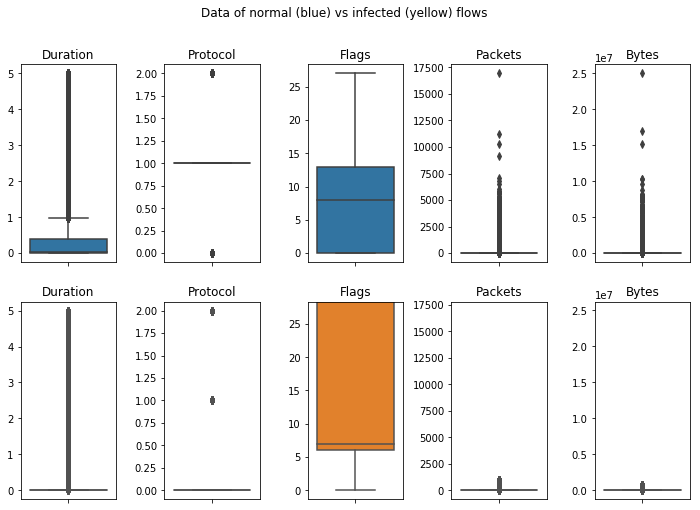

In [13]:
# plot for normal vs infected flows
fig, axes = plt.subplots(2, len(df_vis_normal.columns), figsize=(12, 8))
plt.subplots_adjust(wspace=0.5)

for i, variable in enumerate(df_vis_normal):
    # plot for normal flows
    sns.boxplot(df_vis_normal[variable], orient='v', ax=axes[0, i])
    axes[0, i].set_title(variable)
    axes[0, i].set_ylabel(None)
    
    # plot for infected flows
    sns.boxplot(df_vis_infected[variable], orient='v', ax=axes[1, i], color='C1')
    axes[1, i].set_title(variable)
    axes[1, i].set_ylabel(None)
    axes[1, i].set_ylim(axes[0, i].get_ylim())

fig.suptitle('Data of normal (blue) vs infected (yellow) flows')

#### b. *Pairwise plots*: showing the relation between variables for each of two variables.

In [14]:
df_vis = df.loc[(df.Label != 'Botnet')|(df.ScrAddr == INFECTED_HOST)|(df.DstAddr == INFECTED_HOST)]

# label encoding for categorical variables
for var in categorical_var:
    labelled_var = LabelEncoder().fit_transform(df_vis[var])
    df_vis.loc[:, var] = labelled_var

df_vis.set_index('Time', drop=True, inplace=True)
    
# drop the variables that are not of interest for visualisation (e.g. Time, Scr/DstAddr)
# or have one unique value (Tos=0, Flows=1)
df_vis.drop(columns=['ScrAddr', 'DstAddr', 'Tos', 'Flows'], inplace=True)

C:\Users\Hsin\.conda\envs\deeplearning\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


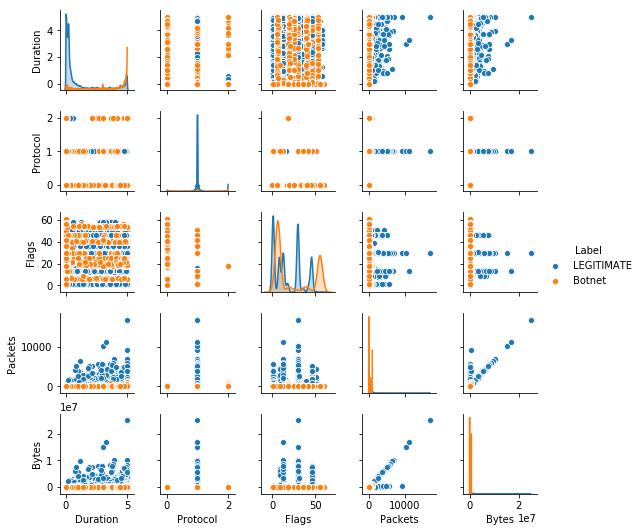

In [15]:
# plot pairplot showing relations between variables
sns.pairplot(df_vis, hue='Label', diag_kind='kde',  height=1.5)

C:\Users\Hsin\.conda\envs\deeplearning\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Text(0.5, 0.93, 'Data flows series: selected features vs label')

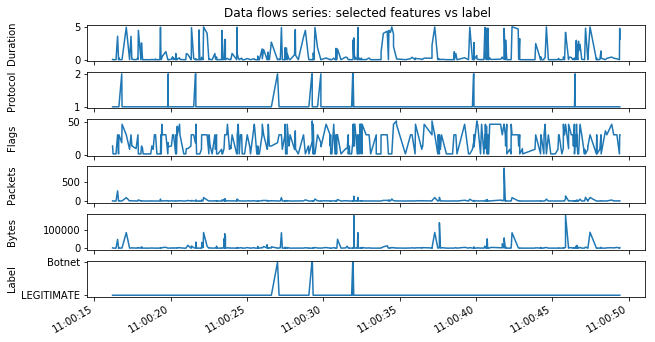

In [16]:
# plot time series of selected features vs label
fig, ax = plt.subplots(len(df_vis.columns), 1, sharex=True, figsize=(10, 5))

for i, variable in enumerate(df_vis.columns):
    ax[i].plot(df_vis[variable][42000:42500]) # zoom-in for better visuals
    ax[i].set_ylabel(variable)

plt.setp(ax[len(df_vis.columns)-1].get_xticklabels(), rotation=30, ha='right')
plt.subplots_adjust(hspace=0.3)
fig.align_ylabels()
fig.suptitle('Data flows series: selected features vs label', y=0.93)

From above graphs, we can see there are some distinguishing charateristics between normal and infected flows as well as few similarities. 

- *Duration*: infected flows mostly have a duration << 1 hr whereas normal flows have an averaged longer duration.

- *Packets* and *Bytes* are quite correlated for both cases of infected flows and normal flows, and the largest chunck of both types of flows are of ~1 Megabytes and < 100 packets. Normal data flows have flows with much larger packets and bytes.

- The most significant difference lies in *Protocol*, where normal flows mostly use UDP (labelled 1) and infected flows mostly use TCP (labelled 0).

- Normal flows and infected flows also have their difference in *Flags*, where normal flows have a more different types of flags.

We select the features of **Protocol and Bytes** for the discretisation tasks.

## 2. Discretisation

In this task, we apply clustering to discretise and combine the two selected features.

In [17]:
from sklearn.preprocessing import scale
from sklearn.cluster import MiniBatchKMeans

# set the scaled features: in this case, Protocol and Bytes
x = df_vis[['Protocol', 'Bytes', 'Label']]
x_scaled = scale(x[['Protocol', 'Bytes']].values)

# initiate clustering algorithm
N_CLUSTERS = 5
BATCH_SIZE = 10
kmeans = MiniBatchKMeans(n_clusters=N_CLUSTERS, batch_size=BATCH_SIZE,
                         random_state=42)

# get the discretised labels
discretised_labels = kmeans.fit_predict(x_scaled)
x['Discretisation'] = discretised_labels # append the results back to dataframe

C:\Users\Hsin\.conda\envs\deeplearning\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Hsin\.conda\envs\deeplearning\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


Text(0.5, 0.93, 'Data flows series: selected features vs label')

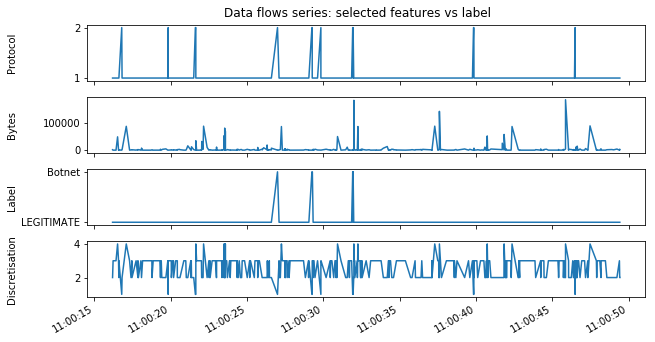

In [18]:
# plot time series of selected features vs label
fig, ax = plt.subplots(len(x.columns), 1, sharex=True, figsize=(10, 5))

for i, variable in enumerate(x.columns):
    ax[i].plot(x[variable][42000:42500]) # zoom-in for better visuals
    ax[i].set_ylabel(variable)

plt.setp(ax[len(x.columns)-1].get_xticklabels(), rotation=30, ha='right')
plt.subplots_adjust(hspace=0.3)
fig.align_ylabels()
fig.suptitle('Data flows series: selected features vs label', y=0.93)